<a href="https://colab.research.google.com/github/GunawanJatiPamungkas/UAS_Gunawan-Jati-Pamungkas_4212201101/blob/main/AAS_Machine_Vision_4212201101_Gunawan_Jati_Pamungkas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('/content/drive/MyDrive/AAS_Machine Vision/emnist-letters-train.csv', nrows=2500)
test_data = pd.read_csv('/content/drive/MyDrive/AAS_Machine Vision/emnist-letters-test.csv', nrows=2500)

In [3]:
# Preproses data latih
x_train = train_data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32') / 255.0
y_train = train_data.iloc[:, 0].values.astype('int')

# Preproses data uji
x_test = test_data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32') / 255.0
y_test = test_data.iloc[:, 0].values.astype('int')

# Ubah ukuran dan normalisasi data
x_train_resized = torch.tensor(x_train).unsqueeze(1)  # Tambahkan dimensi channel
x_test_resized = torch.tensor(x_test).unsqueeze(1)
x_train_resized = torch.nn.functional.interpolate(x_train_resized, size=(224, 224), mode='bilinear')
x_test_resized = torch.nn.functional.interpolate(x_test_resized, size=(224, 224), mode='bilinear')

In [4]:
# Konversi ke RGB
x_train_rgb = x_train_resized.repeat(1, 3, 1, 1)
x_test_rgb = x_test_resized.repeat(1, 3, 1, 1)

# Normalisasi dengan mean dan std untuk ImageNet
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
x_train_normalized = (x_train_rgb - mean) / std
x_test_normalized = (x_test_rgb - mean) / std

# Ubah label menjadi tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Persiapkan data loader
train_dataset = TensorDataset(x_train_normalized, y_train_tensor)
test_dataset = TensorDataset(x_test_normalized, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
all_preds = []
all_true = []

In [6]:
# LOOCV loop (limit to 10 iterations for demonstration)
for i in range(min(10, len(x_train_normalized))):
    print(f"LOOCV Iteration {i + 1}/{min(10, len(x_train_normalized))}")

    # Split data into training and testing
    x_test_cv = x_train_normalized[i:i+1]
    y_test_cv = y_train_tensor[i:i+1]
    x_train_cv = torch.cat((x_train_normalized[:i], x_train_normalized[i+1:]), dim=0)
    y_train_cv = torch.cat((y_train_tensor[:i], y_train_tensor[i+1:]), dim=0)

    # Create DataLoader for training
    train_dataset_cv = TensorDataset(x_train_cv, y_train_cv)
    train_loader_cv = DataLoader(train_dataset_cv, batch_size=16, shuffle=True)

    # Initialize new model for each iteration
    model = models.alexnet(weights='IMAGENET1K_V1')
    model.classifier[6] = nn.Linear(4096, 46)
    model.to(torch.device('cpu'))

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Fase Pelatihan (latih selama 3 epoch untuk demonstrasi)
    model.train()
    for epoch in range(3):
      running_loss = 0.0
      correct_predictions = 0
      for inputs, labels in train_loader_cv:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluasi pada data uji saat ini
    model.eval()
    with torch.no_grad():
      outputs = model(x_test_cv)
      pred = outputs.argmax(dim=1)
      all_preds.extend(pred.numpy())
      all_true.extend(y_test_cv.numpy())

# Compute overall metrics
mean_accuracy = accuracy_score(all_true, all_preds)
mean_precision = precision_score(all_true, all_preds, average='weighted', zero_division=0)
mean_f1_score = f1_score(all_true, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_true, all_preds, labels=range(46))

# Print results
print("=== LOOCV Results ===")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean F1 Score: {mean_f1_score:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

LOOCV Iteration 1/10
LOOCV Iteration 2/10
LOOCV Iteration 3/10
LOOCV Iteration 4/10
LOOCV Iteration 5/10
LOOCV Iteration 6/10
LOOCV Iteration 7/10
LOOCV Iteration 8/10
LOOCV Iteration 9/10
LOOCV Iteration 10/10
=== LOOCV Results ===
Mean Accuracy: 0.9000
Mean Precision: 0.9000
Mean F1 Score: 0.9000
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


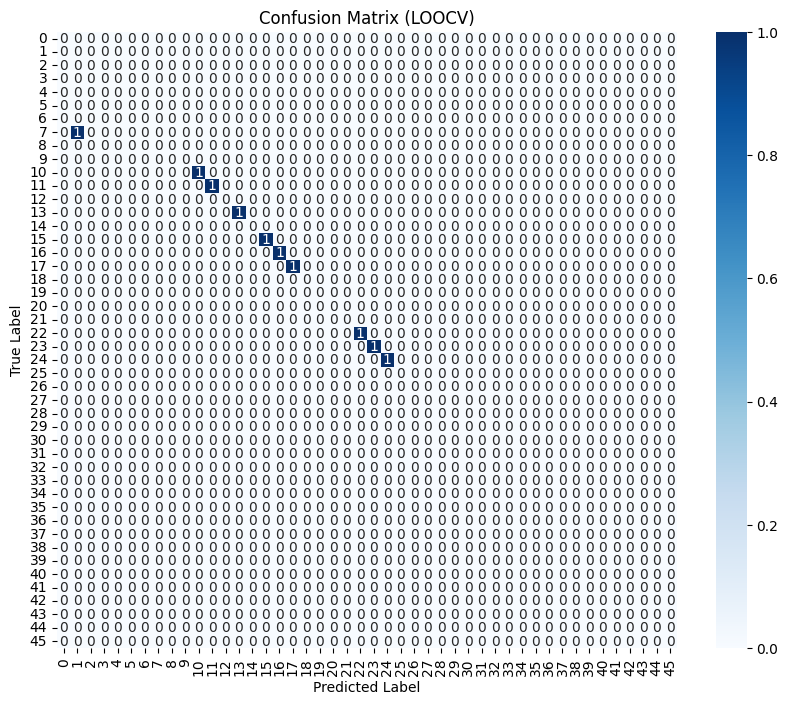

In [7]:
# Plot confusion matrix or further analyze it
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(46), yticklabels=range(46))
plt.title("Confusion Matrix (LOOCV)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()